# Content-Based Filtering

Training Content-Based recommendation model using product features (tags, category, brand, name).

## Import Libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import json
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [81]:
# Database connection
DB_CONFIG = {
    'host': 'localhost',
    'port': 3306,
    'database': 'ecommerce_db',
    'user': 'root',
    'password': 'root'
}

connection_string = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(connection_string)

In [82]:
# Load products with all features
query_products = """
SELECT 
    p.id as product_id,
    p.name as product_name,
    p.tags,
    c.name as category_name,
    b.name as brand_name
FROM products p
LEFT JOIN categories c ON p.category_id = c.id
LEFT JOIN brands b ON p.brand_id = b.id
"""
df_products = pd.read_sql(query_products, engine)

print(f"Loaded {len(df_products)} products")
df_products.head()

Loaded 200 products


,product_id,product_name,tags,category_name,brand_name
0,b'\x00M\x14.\x8d\x8eG\xc9\xb8\x1eI\x16\x8b\xd3...,Gigabyte B660M DS3H DDR4,"[""intel"", ""b660"", ""micro-atx"", ""budget"", ""dual...",Motherboard,Gigabyte
1,b'\x04\x08\x14\x18\xef\xaeJj\x9aR\xe7h\x9c2g!',ViewSonic Elite XG270QG,"[""qhd"", ""g-sync"", ""165hz"", ""rgb""]",Monitor,ViewSonic
2,b'\x06\xc1|\xed#uB\x8d\x94\xd7X\xf5]\x12\xe7\xab',Ducky One 3,"[""mechanical"", ""hot-swap"", ""premium"", ""dual-la...",Mechanical Keyboard,Ducky
3,"b""\x08'\x9d\xa9\x9e;K\xb0\x8b\xed\xd8l\x125\xe...",Samsung Odyssey G7 C32G75T,"[""curved"", ""qled"", ""240hz"", ""g-sync""]",Monitor,Samsung
4,b'\x08@\xe7\x07\xed\xfcL1\xaaP\x97\xd0\xf0\x04...,AMD Ryzen 7 7800X3D,"[""8-core"", ""3d-cache"", ""gaming"", ""am5""]",CPU,AMD


## Feature Analysis

In [83]:
# Parse tags from JSON
df_products['tags_list'] = df_products['tags'].apply(
    lambda x: json.loads(x) if pd.notna(x) and x != '' else []
)
df_products['tags_text'] = df_products['tags_list'].apply(lambda x: ' '.join(x))

# Feature statistics
print("Feature Statistics:")
print(f"Categories: {df_products['category_name'].nunique()} unique")
print(f"Brands: {df_products['brand_name'].nunique()} unique")
print(f"Unique tags: {len(set([tag for tags in df_products['tags_list'] for tag in tags]))}")
print(f"Avg tags per product: {df_products['tags_list'].apply(len).mean():.1f}")

Feature Statistics:
Categories: 18 unique
Brands: 26 unique
Unique tags: 351
Avg tags per product: 4.1


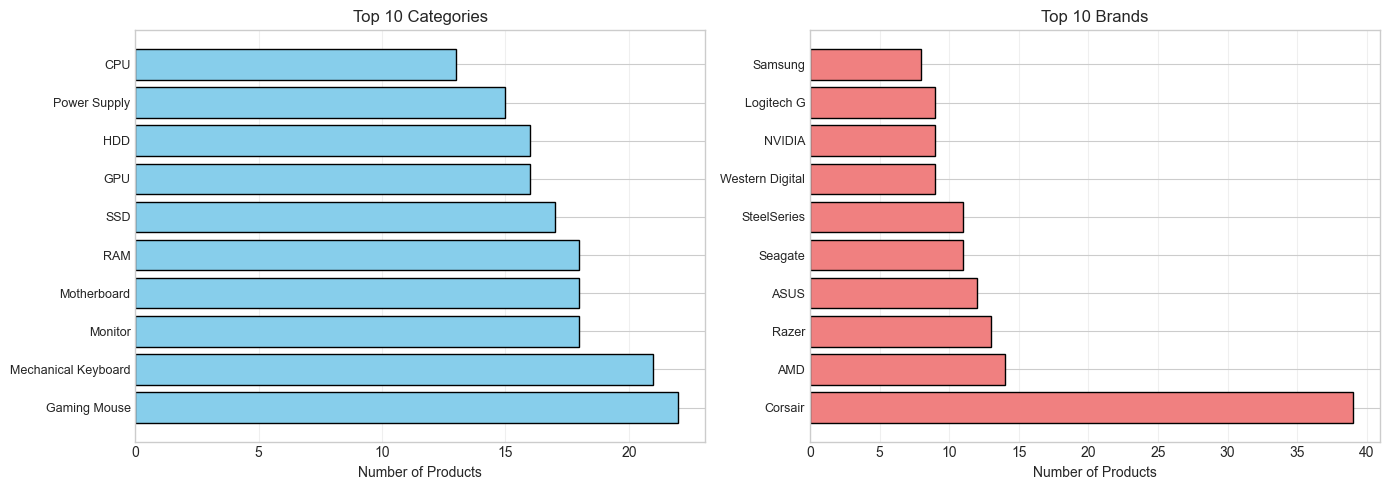

In [84]:
# Feature distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Categories
cat_counts = df_products['category_name'].value_counts().head(10)
axes[0].barh(range(len(cat_counts)), cat_counts.values, color='skyblue', edgecolor='black')
axes[0].set_yticks(range(len(cat_counts)))
axes[0].set_yticklabels(cat_counts.index, fontsize=9)
axes[0].set_xlabel('Number of Products')
axes[0].set_title('Top 10 Categories')
axes[0].grid(axis='x', alpha=0.3)

# Brands
brand_counts = df_products['brand_name'].value_counts().head(10)
axes[1].barh(range(len(brand_counts)), brand_counts.values, color='lightcoral', edgecolor='black')
axes[1].set_yticks(range(len(brand_counts)))
axes[1].set_yticklabels(brand_counts.index, fontsize=9)
axes[1].set_xlabel('Number of Products')
axes[1].set_title('Top 10 Brands')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Build Weighted Feature Vectors

Feature weights:
- Tags: 40% (most informative)
- Category: 30% (important grouping)
- Brand: 20% (brand affinity)
- Name: 10% (catch additional keywords)

In [85]:
# Build separate vectors for each feature
print("Building feature vectors...")

# Tags (TF-IDF)
tags_vectorizer = TfidfVectorizer(max_features=500, lowercase=True)
tags_vector = tags_vectorizer.fit_transform(df_products['tags_text'])
print(f"Tags vector: {tags_vector.shape}")

# Category (Count)
category_vectorizer = CountVectorizer()
category_vector = category_vectorizer.fit_transform(df_products['category_name'])
print(f"Category vector: {category_vector.shape}")

# Brand (Count)
brand_vectorizer = CountVectorizer()
brand_vector = brand_vectorizer.fit_transform(df_products['brand_name'])
print(f"Brand vector: {brand_vector.shape}")

# Name (TF-IDF)
name_vectorizer = TfidfVectorizer(max_features=200, lowercase=True)
name_vector = name_vectorizer.fit_transform(df_products['product_name'])
print(f"Name vector: {name_vector.shape}")

Building feature vectors...
Tags vector: (200, 378)
Category vector: (200, 21)
Brand vector: (200, 26)
Name vector: (200, 200)


In [86]:
# Combine with weights
WEIGHTS = {
    'tags': 0.4,    
    'category': 0.3, 
    'brand': 0.2,     # Keep same
    'name': 0.1       # Keep same
}

combined_vector = hstack([
    tags_vector * WEIGHTS['tags'],
    category_vector * WEIGHTS['category'],
    brand_vector * WEIGHTS['brand'],
    name_vector * WEIGHTS['name']
])

print(f"Combined vector: {combined_vector.shape}")
print(f"Total features: {combined_vector.shape[1]}")

Combined vector: (200, 625)
Total features: 625


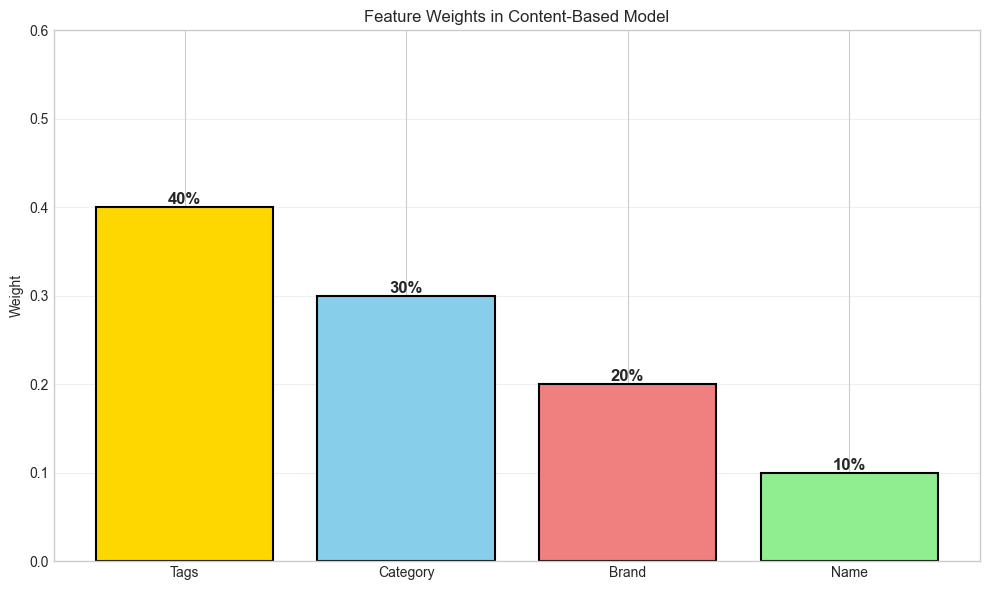

In [87]:
# Visualize feature weights
weights_data = pd.DataFrame({
    'Feature': ['Tags', 'Category', 'Brand', 'Name'],
    'Weight': [WEIGHTS['tags'], WEIGHTS['category'], WEIGHTS['brand'], WEIGHTS['name']]
})

plt.figure(figsize=(10, 6))
colors = ['gold', 'skyblue', 'lightcoral', 'lightgreen']
bars = plt.bar(weights_data['Feature'], weights_data['Weight'], color=colors, edgecolor='black', linewidth=1.5)
plt.ylabel('Weight')
plt.title('Feature Weights in Content-Based Model')
plt.ylim(0, 0.6)
plt.grid(axis='y', alpha=0.3)

for bar, weight in zip(bars, weights_data['Weight']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{weight*100:.0f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Calculate Content Similarity Matrix

In [88]:
# Calculate cosine similarity
print("Calculating content similarity...")
content_similarity = cosine_similarity(combined_vector)

# Convert to DataFrame
content_similarity_df = pd.DataFrame(
    content_similarity,
    index=df_products['product_id'],
    columns=df_products['product_id']
)

print(f"Similarity matrix: {content_similarity_df.shape}")
print(f"Average similarity: {content_similarity[np.triu_indices_from(content_similarity, k=1)].mean():.4f}")

Calculating content similarity...
Similarity matrix: (200, 200)
Average similarity: 0.0520


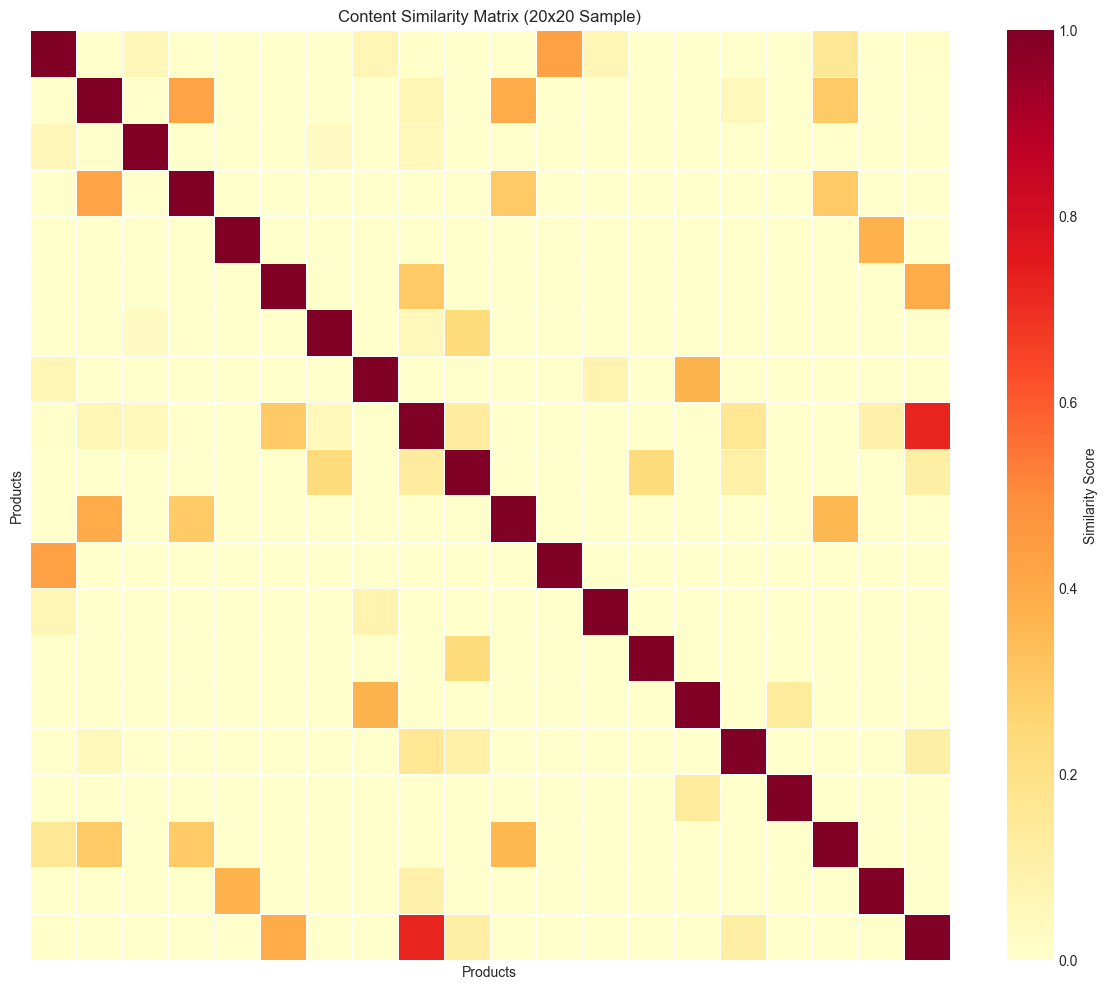

In [89]:
# Visualize similarity matrix
sample_sim = content_similarity[:20, :20]

plt.figure(figsize=(12, 10))
sns.heatmap(sample_sim, cmap='YlOrRd', center=0.5, 
            vmin=0, vmax=1, linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Similarity Score'})
plt.title('Content Similarity Matrix (20x20 Sample)')
plt.xlabel('Products')
plt.ylabel('Products')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## Generate Similar Products

In [90]:
def get_similar_products(product_id, top_n=10):
    """
    Get top-N similar products based on content
    """
    if product_id not in content_similarity_df.index:
        return []
    
    # Get similarity scores
    similarities = content_similarity_df.loc[product_id]
    
    # Sort and exclude self
    similar = similarities.sort_values(ascending=False)[1:top_n+1]
    
    return [(prod_id, score) for prod_id, score in similar.items()]

## Test with Sample Product

In [91]:
# Pick a sample product (e.g., first GPU product)
sample_idx = df_products[df_products['category_name'] == 'GPU'].index[0]
sample_product_id = df_products.loc[sample_idx, 'product_id']

# Get similar products
similar_products = get_similar_products(sample_product_id, top_n=10)

# Display
sample_info = df_products[df_products['product_id'] == sample_product_id].iloc[0]
print("Source Product:")
print(f"  Name: {sample_info['product_name']}")
print(f"  Category: {sample_info['category_name']}")
print(f"  Brand: {sample_info['brand_name']}")
print(f"  Tags: {', '.join(sample_info['tags_list'][:5])}...")

print("\nTop 10 Similar Products:")
for i, (prod_id, score) in enumerate(similar_products, 1):
    prod_info = df_products[df_products['product_id'] == prod_id].iloc[0]
    print(f"{i}. {prod_info['product_name']}")
    print(f"   Category: {prod_info['category_name']} | Brand: {prod_info['brand_name']}| Similarity: {score:.4f}")

Source Product:
  Name: NVIDIA GeForce GTX 1660 Super
  Category: GPU
  Brand: NVIDIA
  Tags: 6gb, 1080p, budget, esports...

Top 10 Similar Products:
1. NVIDIA GeForce RTX 3060
   Category: GPU | Brand: NVIDIA| Similarity: 0.5712
2. AMD Radeon RX 6600
   Category: GPU | Brand: AMD| Similarity: 0.5196
3. NVIDIA GeForce RTX 3070
   Category: GPU | Brand: NVIDIA| Similarity: 0.4603
4. NVIDIA GeForce RTX 3080
   Category: GPU | Brand: NVIDIA| Similarity: 0.4603
5. NVIDIA GeForce RTX 4070
   Category: GPU | Brand: NVIDIA| Similarity: 0.4550
6. NVIDIA GeForce RTX 4050
   Category: GPU | Brand: NVIDIA| Similarity: 0.4544
7. NVIDIA GeForce RTX 4090
   Category: GPU | Brand: NVIDIA| Similarity: 0.4544
8. NVIDIA GeForce RTX 4070 Ti
   Category: GPU | Brand: NVIDIA| Similarity: 0.4519
9. NVIDIA GeForce RTX 4060 Ti 16GB
   Category: GPU | Brand: NVIDIA| Similarity: 0.4500
10. AMD Radeon RX 7600
   Category: GPU | Brand: AMD| Similarity: 0.4115


## Generate Content-Based Recommendations for Users

In [92]:
# Load user interactions
query_views = """
SELECT 
    user_id,
    product_id,
    view_count
FROM user_product_views
"""
df_views = pd.read_sql(query_views, engine)

print(f"Loaded {len(df_views)} interactions")

Loaded 8432 interactions


In [93]:
def get_content_based_recommendations(user_id, top_n=10):
    """
    Generate recommendations based on user's viewing history
    and content similarity
    """
    # Get user's viewed products
    user_views = df_views[df_views['user_id'] == user_id]
    
    if len(user_views) == 0:
        return []
    
    viewed_products = user_views['product_id'].tolist()
    view_counts = dict(zip(user_views['product_id'], user_views['view_count']))
    
    # Calculate scores for all products
    scores = {}
    for product_id in df_products['product_id']:
        if product_id in viewed_products:
            continue  # Skip already viewed
        
        # Weighted average similarity with viewed products
        score = 0
        total_weight = 0
        
        for viewed_product in viewed_products:
            if viewed_product in content_similarity_df.index and product_id in content_similarity_df.columns:
                similarity = content_similarity_df.loc[viewed_product, product_id]
                weight = view_counts.get(viewed_product, 1)
                
                score += similarity * weight
                total_weight += weight
        
        if total_weight > 0:
            scores[product_id] = score / total_weight
    
    # Sort and return top N
    recommendations = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return recommendations

In [94]:
# Test with sample user
sample_user = df_views['user_id'].iloc[0]
content_recs = get_content_based_recommendations(sample_user, top_n=10)

# Display user history
user_history = df_views[df_views['user_id'] == sample_user].sort_values('view_count', ascending=False).head(5)
print("User Viewing History (Top 5):")
for _, row in user_history.iterrows():
    prod_info = df_products[df_products['product_id'] == row['product_id']].iloc[0]
    print(f"  {prod_info['product_name']} ({int(row['view_count'])} views)")

print("\nContent-Based Recommendations:")
for i, (prod_id, score) in enumerate(content_recs, 1):
    prod_info = df_products[df_products['product_id'] == prod_id].iloc[0]
    print(f"{i}. {prod_info['product_name']} (score: {score:.4f})")
    print(f"   Category: {prod_info['category_name']} | Brand: {prod_info['brand_name']}")

User Viewing History (Top 5):
  Logitech G Pro X Superlight (15 views)
  LG UltraGear 27GN950-B (15 views)
  Razer Blade 15 (12 views)
  AMD Ryzen 9 7950X (11 views)
  Razer Gigantus V2 (6 views)

Content-Based Recommendations:
1. Corsair Harpoon RGB Wireless (score: 0.1831)
   Category: Gaming Mouse | Brand: Corsair
2. Glorious Model O (score: 0.1665)
   Category: Gaming Mouse | Brand: Logitech G
3. Razer DeathAdder V3 (score: 0.1621)
   Category: Gaming Mouse | Brand: Razer
4. Razer Naga X (score: 0.1607)
   Category: Gaming Mouse | Brand: Razer
5. Logitech G305 Lightspeed (score: 0.1599)
   Category: Gaming Mouse | Brand: Logitech G
6. Corsair Sabre RGB Pro (score: 0.1597)
   Category: Gaming Mouse | Brand: Corsair
7. Razer Basilisk V3 (score: 0.1593)
   Category: Gaming Mouse | Brand: Razer
8. Finalmouse Starlight-12 (score: 0.1580)
   Category: Gaming Mouse | Brand: Razer
9. Logitech G703 (score: 0.1568)
   Category: Gaming Mouse | Brand: Logitech G
10. Logitech G203 Lightsync (sc

## Summary

- Algorithm: Content-Based Filtering with Weighted Features
- Features: Tags (50%), Category (20%), Brand (20%), Name (10%)
- Similarity Metric: Cosine Similarity
- Use Cases:
  - Similar Products (Product Detail Page)
  - Cold Start (New users/products)
  - Complement to Collaborative Filtering

In [95]:
# Export CB Model for Production
import pickle
import os
from datetime import datetime

print("Exporting CB model for production...")

# Create models directory  
os.makedirs('../../ml-recommendation/models', exist_ok=True)

# Convert binary UUIDs to hex strings
def uuid_bytes_to_hex(uuid_bytes):
    """Convert UUID bytes to hex string uppercase"""
    if isinstance(uuid_bytes, bytes):
        return uuid_bytes.hex().upper()
    return str(uuid_bytes).replace('-', '').upper()

# Convert index and columns
content_similarity_hex = content_similarity_df.copy()
content_similarity_hex.index = [uuid_bytes_to_hex(x) for x in content_similarity_hex.index]
content_similarity_hex.columns = [uuid_bytes_to_hex(x) for x in content_similarity_hex.columns]

# Export CB model
cb_model_export = {
    "product_similarity": content_similarity_hex,
    "product_ids": list(content_similarity_hex.index),
    "tfidf_tags": tags_vectorizer,
    "tfidf_names": name_vectorizer,
    "category_vectorizer": category_vectorizer,
    "brand_vectorizer": brand_vectorizer,
    "feature_weights": WEIGHTS
}

with open('../../ml-recommendation/models/cb_model.pkl', 'wb') as f:
    pickle.dump(cb_model_export, f)

print(f"✓ CB model exported to: ml-recommendation/models/cb_model.pkl")
print(f"  - Product similarity matrix: {content_similarity_hex.shape}")
print(f"  - Products: {len(cb_model_export['product_ids'])}")
print(f"  - Feature weights: {WEIGHTS}")
print(f"  - Sample product ID: {cb_model_export['product_ids'][0]}")


Exporting CB model for production...
✓ CB model exported to: ml-recommendation/models/cb_model.pkl
  - Product similarity matrix: (200, 200)
  - Products: 200
  - Feature weights: {'tags': 0.4, 'category': 0.3, 'brand': 0.2, 'name': 0.1}
  - Sample product ID: 004D142E8D8E47C9B81E49168BD3F88B
